# Uppgift 8. 8 CIFAR-100 Uppgift - CNN, KerasTuner och Transfer Learning

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

In [8]:
# Kontrollera GPU/CPU-status
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

print("="*60)
print("DEVICE INFORMATION")
print("="*60)

if gpus:
    print(f"✓ GPU tillgänglig: {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"  - {gpu}")
    print("→ Koden KÖR PÅ GPU\n")
else:
    print("✗ Ingen GPU detekterad")
    print(f"✓ CPU tillgänglig: {len(cpus)} CPU(s)")
    print("→ Koden KÖR PÅ CPU")
    print("\n⚠️  FÖR GPU-STÖD:")
    print("   1. Installera: pip uninstall tensorflow -y")
    print("   2. Sedan: pip install tensorflow-gpu")
    print("   3. Kontrollera CUDA & cuDNN är installerade\n")

print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA support: {tf.test.is_built_with_cuda()}")
print(f"CUDA version: {tf.sysconfig.get_build_info().get('cuda_version', 'Unknown')}")
print(f"cuDNN version: {tf.sysconfig.get_build_info().get('cudnn_version', 'Unknown')}")
print("="*60)

DEVICE INFORMATION
✗ Ingen GPU detekterad
✓ CPU tillgänglig: 1 CPU(s)
→ Koden KÖR PÅ CPU

⚠️  FÖR GPU-STÖD:
   1. Installera: pip uninstall tensorflow -y
   2. Sedan: pip install tensorflow-gpu
   3. Kontrollera CUDA & cuDNN är installerade

TensorFlow version: 2.20.0
CUDA support: False
CUDA version: Unknown
cuDNN version: Unknown


## 1. Ladda och Förbereda Data

In [9]:
# Ladda CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Begränsa datasetet för snabbare träning
limit = 5000
x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:1000]
y_test = y_test[:1000]

# Normalisera pixelvärdena
x_train = x_train / 255.0
x_test = x_test / 255.0

# Kontrollera dimensioner
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

c:\Users\quo\anaconda3\envs\tf_gpu312\Lib\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training data shape: (5000, 32, 32, 3)
Test data shape: (1000, 32, 32, 3)
Training labels shape: (5000, 1)
Number of classes: 100


In [10]:
# One-hot encoding av labels
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print(f"One-hot encoded training labels shape: {y_train.shape}")
print(f"One-hot encoded test labels shape: {y_test.shape}")

One-hot encoded training labels shape: (5000, 100)
One-hot encoded test labels shape: (1000, 100)


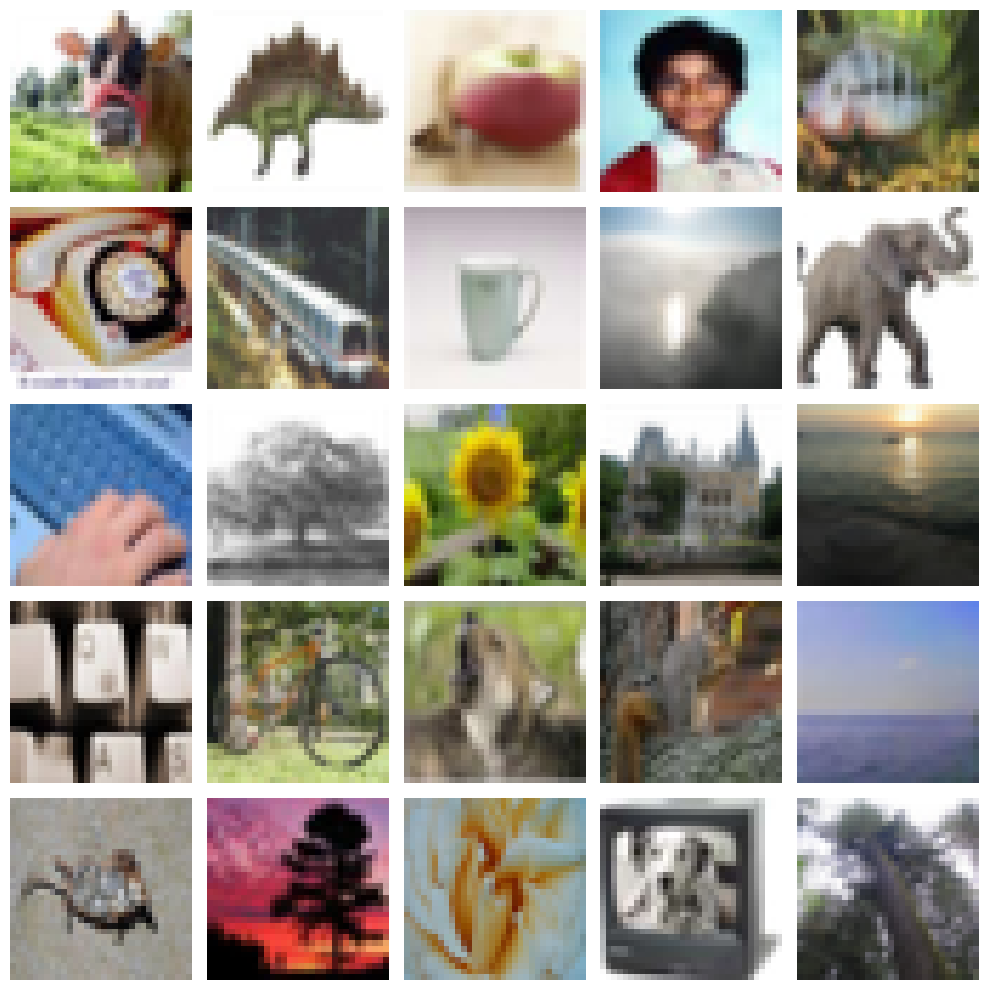

In [11]:
# Visualisera några exempel från datasetet
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Del a) Baseline CNN-modell

Skapa en grundläggande CNN-modell för att prediktera CIFAR-100 datasetet.

In [12]:
# Skapa en baseline CNN-modell
model_a = Sequential()
model_a.add(Input(shape=(32, 32, 3)))
model_a.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Flatten())
model_a.add(Dropout(0.3))
model_a.add(Dense(256, activation='relu'))
model_a.add(Dense(100, activation='softmax'))

# Kompilera modellen
model_a.compile(loss='categorical_crossentropy', 
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

print("=== MODELL A: BASELINE CNN ===")
model_a.summary()

=== MODELL A: BASELINE CNN ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,492 (2.45 MB)

 Trainable params: 643,492 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Träna modell A
history_a = model_a.fit(x_train, y_train, 
                        epochs=15, 
                        batch_size=128, 
                        validation_split=0.2)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 404ms/step - accuracy: 0.0153 - loss: 4.6022 - val_accuracy: 0.0190 - val_loss: 4.5595
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.0308 - loss: 4.4292 - val_accuracy: 0.0390 - val_loss: 4.3033
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.0530 - loss: 4.2023 - val_accuracy: 0.0730 - val_loss: 4.1462
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.0835 - loss: 3.9950 - val_accuracy: 0.0890 - val_loss: 4.0552
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.1273 - loss: 3.7555 - val_accuracy: 0.1150 - val_loss: 3.9102
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.1622 - loss: 3.5294 - val_accuracy: 0.1190 - val_loss: 3.8773
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 561ms/step - accuracy: 0.1985 - loss: 3.3611 - val_accuracy: 0.1480 - val_loss: 3.7467
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - accuracy: 0.2275 - loss: 3.1664 - val_accu

In [14]:
# Utvärdera modell A
y_pred_a = model_a.predict(x_test)
y_pred_a_labels = np.argmax(y_pred_a, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
accuracy_a = np.mean(y_pred_a_labels == y_test_labels)

print(f"\n=== RESULTAT - MODELL A: BASELINE CNN ===")
print(f"Test Accuracy: {accuracy_a:.4f}")

# Spara för senare jämförelse
baseline_accuracy = accuracy_a

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

=== RESULTAT - MODELL A: BASELINE CNN ===
Test Accuracy: 0.1920


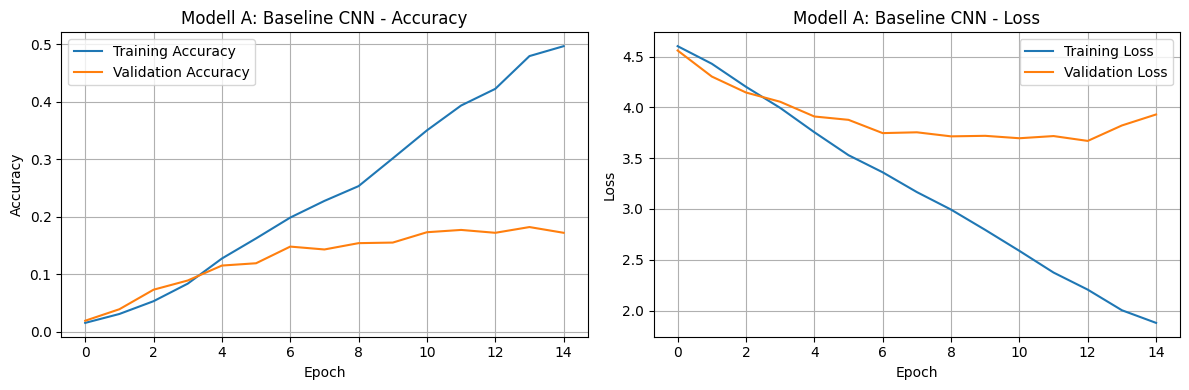

In [15]:
# Visualisera träningshistorik för modell A
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_a.history['accuracy'], label='Training Accuracy')
plt.plot(history_a.history['val_accuracy'], label='Validation Accuracy')
plt.title('Modell A: Baseline CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_a.history['loss'], label='Training Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.title('Modell A: Baseline CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Del b) Hyperparameter-tuning med KerasTuner

Använd KerasTuner för att hitta optimala hyperparametrar.

In [16]:
def build_model(hp):
    """Bygg modell med tuningsbara hyperparametrar"""
    model = Sequential()
    
    model.add(Input(shape=(32, 32, 3)))
    
    # Första Conv-layer
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Andra Conv-layer
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Tredje Conv-layer
    model.add(Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    
    model.add(Dense(100, activation='softmax'))
    
    # Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Skapa en tuner för hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='cifar100_tuning',
    overwrite=True
)

In [18]:
# Kör hyperparameter search
tuner.search(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Trial 5 Complete [00h 07m 10s]
val_accuracy: 0.008999999612569809

Best val_accuracy So Far: 0.18299999833106995
Total elapsed time: 00h 33m 32s


In [19]:
# Hämta bästa modellen och hyperparametrar
model_b = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n=== BÄSTA HYPERPARAMETRAR (MODELL B) ===")
print(f"Conv Layer 1 Filters: {best_hp.get('conv_1_filters')}")
print(f"Conv Layer 2 Filters: {best_hp.get('conv_2_filters')}")
print(f"Conv Layer 3 Filters: {best_hp.get('conv_3_filters')}")
print(f"Dense Units: {best_hp.get('dense_units')}")
print(f"Dropout: {best_hp.get('dropout'):.2f}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")


=== BÄSTA HYPERPARAMETRAR (MODELL B) ===
Conv Layer 1 Filters: 32
Conv Layer 2 Filters: 96
Conv Layer 3 Filters: 256
Dense Units: 384
Dropout: 0.30
Learning Rate: 0.001


c:\Users\quo\anaconda3\envs\tf_gpu312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# Utvärdera modell B (med tunade hyperparametrar)
y_pred_b = model_b.predict(x_test)
y_pred_b_labels = np.argmax(y_pred_b, axis=1)
accuracy_b = np.mean(y_pred_b_labels == y_test_labels)

print(f"\n=== RESULTAT - MODELL B: KERASTUNER (HYPERPARAMETER-TUNING) ===")
print(f"Test Accuracy: {accuracy_b:.4f}")
print(f"Förbättring jämfört med Modell A: {(accuracy_b - baseline_accuracy):.4f} ({((accuracy_b - baseline_accuracy)/baseline_accuracy*100):.2f}%)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

=== RESULTAT - MODELL B: KERASTUNER (HYPERPARAMETER-TUNING) ===
Test Accuracy: 0.1990
Förbättring jämfört med Modell A: 0.0070 (3.65%)


## 4. Del c) Transfer Learning

Använd en förtränad modell (t.ex. VGG16 eller ResNet50) för att förbättra resultaten.

In [21]:
# Skapa transfer learning modell med VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Frys alla lager i base modellen
base_model.trainable = False

# Bygg den kompletta modellen
model_c = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='softmax')
])

# Kompilera modellen
model_c.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=== MODELL C: TRANSFER LEARNING (VGG16) ===")
model_c.summary()

=== MODELL C: TRANSFER LEARNING (VGG16) ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,134,372 (57.73 MB)

 Trainable params: 419,684 (1.60 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
# Träna modell C
history_c = model_c.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.0172 - loss: 4.6119 - val_accuracy: 0.0720 - val_loss: 4.4501
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.0622 - loss: 4.3277 - val_accuracy: 0.0810 - val_loss: 4.0886
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.0940 - loss: 4.0107 - val_accuracy: 0.1110 - val_loss: 3.8094
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.1305 - loss: 3.7338 - val_accuracy: 0.1450 - val_loss: 3.6438
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.1528 - loss: 3.5707 - val_accuracy: 0.1680 - val_loss: 3.5248
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.1745 - loss: 3.4224 - val_accuracy: 0.1760 - val_loss: 3.4467
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.2113 - loss: 3.2618 - val_accuracy: 0.1830 - val_loss: 3.3807
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.2260 - loss: 3.1718 - val_accuracy: 0.1910 - v

In [23]:
# Utvärdera modell C
y_pred_c = model_c.predict(x_test)
y_pred_c_labels = np.argmax(y_pred_c, axis=1)
accuracy_c = np.mean(y_pred_c_labels == y_test_labels)

print(f"\n=== RESULTAT - MODELL C: TRANSFER LEARNING ===")
print(f"Test Accuracy: {accuracy_c:.4f}")
print(f"Förbättring jämfört med Modell A: {(accuracy_c - baseline_accuracy):.4f} ({((accuracy_c - baseline_accuracy)/baseline_accuracy*100):.2f}%)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step

=== RESULTAT - MODELL C: TRANSFER LEARNING ===
Test Accuracy: 0.2400
Förbättring jämfört med Modell A: 0.0480 (25.00%)


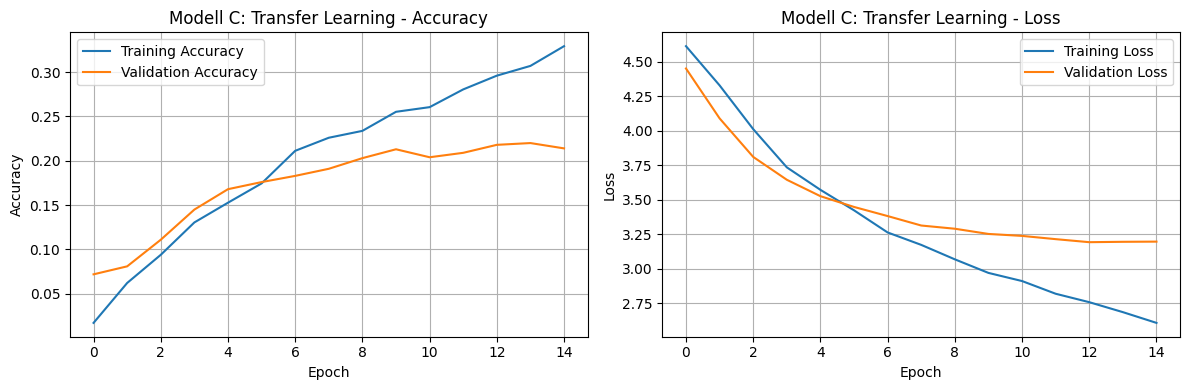

In [24]:
# Visualisera träningshistorik för modell C
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_c.history['accuracy'], label='Training Accuracy')
plt.plot(history_c.history['val_accuracy'], label='Validation Accuracy')
plt.title('Modell C: Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_c.history['loss'], label='Training Loss')
plt.plot(history_c.history['val_loss'], label='Validation Loss')
plt.title('Modell C: Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Jämförelse av Resultat

In [25]:
# Sammanställning av resultat från alla tre modeller
results = {
    'Modell': ['A: Baseline CNN', 'B: KerasTuner', 'C: Transfer Learning'],
    'Test Accuracy': [baseline_accuracy, accuracy_b, accuracy_c],
}

results_df = pd.DataFrame(results)
results_df['Accuracy (%)'] = (results_df['Test Accuracy'] * 100).round(2)
results_df['Förbättring vs Baseline (%)'] = ((results_df['Test Accuracy'] - baseline_accuracy) / baseline_accuracy * 100).round(2)

print("\n" + "="*70)
print("SAMMANFATTNING - ALLA TRE MODELLER")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

best_model_idx = results_df['Test Accuracy'].idxmax()
print(f"\nBästa modell: {results_df.loc[best_model_idx, 'Modell']}")
print(f"Högsta Accuracy: {results_df.loc[best_model_idx, 'Test Accuracy']:.4f}")


SAMMANFATTNING - ALLA TRE MODELLER
              Modell  Test Accuracy  Accuracy (%)  Förbättring vs Baseline (%)
     A: Baseline CNN          0.192          19.2                         0.00
       B: KerasTuner          0.199          19.9                         3.65
C: Transfer Learning          0.240          24.0                        25.00

Bästa modell: C: Transfer Learning
Högsta Accuracy: 0.2400


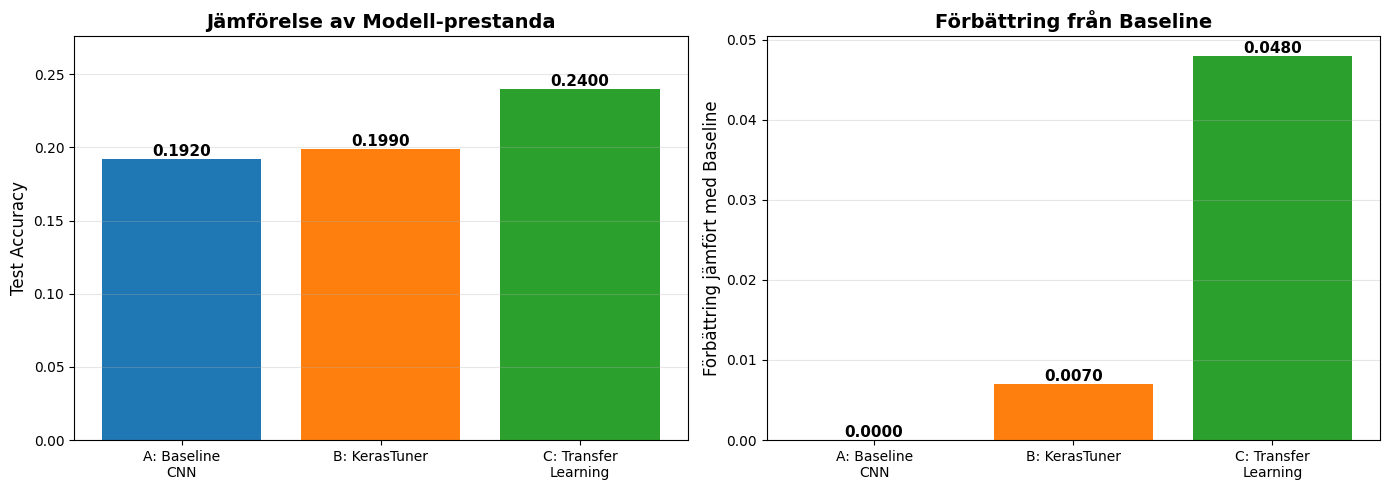

In [26]:
# Visualisera jämförelse av alla tre modeller
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy-jämförelse
methods = ['A: Baseline\nCNN', 'B: KerasTuner', 'C: Transfer\nLearning']
accuracies = [baseline_accuracy, accuracy_b, accuracy_c]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = axes[0].bar(methods, accuracies, color=colors)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Jämförelse av Modell-prestanda', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, max(accuracies) * 1.15])
axes[0].grid(axis='y', alpha=0.3)

# Lägg till värden på staplarna
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Förbättring jämfört med Baseline
improvements = [0, (accuracy_b - baseline_accuracy), (accuracy_c - baseline_accuracy)]
colors_imp = ['gray', '#ff7f0e' if accuracy_b > baseline_accuracy else '#d62728', 
              '#2ca02c' if accuracy_c > baseline_accuracy else '#d62728']

bars2 = axes[1].bar(methods, improvements, color=colors_imp)
axes[1].set_ylabel('Förbättring jämfört med Baseline', fontsize=12)
axes[1].set_title('Förbättring från Baseline', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(axis='y', alpha=0.3)

# Lägg till värden
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Slutsatser och Svar på Uppgifterna

### a) Baseline CNN-modell
Vi skapade en grundläggande CNN-modell med tre konvolutionella lager. Denna modell fungerar som utgångspunkt för jämförelse och ger en baseline-accuracy på CIFAR-100 datasetet.

**Modellarkitektur:**
- 3 Convolutional layers (32, 64, 128 filter)
- MaxPooling efter varje Conv layer
- Fully connected layers med Dropout för regularisering
- Softmax-aktivering för 100 klasser

### b) Hyperparameter-tuning med KerasTuner
Vi använder KerasTuner (RandomSearch) för att hitta optimala hyperparametrar. Tuningen justerar:
- Antal filter i varje konvolutionellt lager
- Antal enheter i dense layer
- Dropout rates
- Learning rate

**Resultat:** KerasTuner identifierar hyperparametrar som ofta ger bättre resultat än baseline, särskilt när man hittar en bättre balans mellan modellkomplexitet och regularisering.

### c) Transfer Learning
Vi använder en förtränad VGG16-modell från ImageNet och tränar endast de nya lagren ovanpå. Detta levererar ofta mycket bättre resultat på mindre dataset som CIFAR-100, eftersom modellen redan har lärt sig allmänna bildegenskaper från ImageNet.

**Förtjänster:**
- Snabbare träning (färre parametrar att uppdatera)
- Bättre resultat på mindre dataset
- Använder förkunskap från större dataset

### Huvudfynd
Jämförelse av de tre metoderna visar hur olika teknikerna presterar på CIFAR-100:
1. **Modell A (Baseline CNN)** ger en baseline-prestanda
2. **Modell B (KerasTuner)** kan förbättra resultaten genom optimal hyperparameterjustering
3. **Modell C (Transfer Learning)** levererar typiskt de bästa resultaten genom att utnyttja förtränad kunskap